# LSTM Transfer Learning

In [1]:
# !pip install tensorflow
# !pip install tensorflow_hub

In [2]:
import pandas as pd
import numpy as np
from tqdm import tqdm
import random
import tensorflow as tf
from sklearn.metrics import mean_squared_error
import eli5
from eli5.sklearn import PermutationImportance
import seaborn as sns
import matplotlib.pyplot as plt
import os
import shap
tf.config.list_physical_devices('GPU')

pd.options.display.max_columns = 100

C:\Users\weroo\Anaconda\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:144: FutureWarning: The sklearn.metrics.scorer module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)
C:\Users\weroo\Anaconda\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:144: FutureWarning: The sklearn.feature_selection.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.feature_selection. Anything that cannot be imported from sklearn.feature_selection is now part of the private API.
  warnings.warn(message, FutureWarning)
Using TensorFlow backend.


In [3]:
print(tf.__version__)

2.0.0


In [4]:
# 재생산성을 위해 시드 고정
np.random.seed(7)
random.seed(7)
tf.random.set_seed(7)

In [5]:
train_raw = pd.read_csv('data/train.csv')
test_raw = pd.read_csv('data/test.csv')

In [6]:
train_raw.head()

,id,X00,X01,X02,X03,X04,X05,X06,X07,X08,X09,X10,X11,X12,X13,X14,X15,X16,X17,X18,X19,X20,X21,X22,X23,X24,X25,X26,X27,X28,X29,X30,X31,X32,X33,X34,X35,X36,X37,X38,X39,Y00,Y01,Y02,Y03,Y04,Y05,Y06,Y07,Y08,Y09,Y10,Y11,Y12,Y13,Y14,Y15,Y16,Y17,Y18
0,0,9.7,988.8,1.2,0.6,0.0,1009.3,989.6,12.2,1009.9,1009.8,0.0,0.0,82.4,71.3,0.0,101.1,0.0,56.1,0.3,0.0,91.0,0.0,1002.5,1009.8,1.1,2.3,0.5,1008.7,12.3,1001.6,69.1,8.2,10.7,1010.1,0.0,256.4,0.0,77.2,62.6,0.0,12.5,11.5,11.0,20.0,20.0,10.5,10.0,10.5,10.0,7.0,7.5,7.0,9.0,10.0,9.5,9.0,8.0,9.0,NaN
1,1,9.3,988.9,1.7,1.9,0.0,1009.3,989.6,12.1,1010.0,1009.9,0.0,0.0,81.2,121.8,0.0,165.3,0.0,0.0,0.4,0.0,91.9,0.0,1002.5,1009.9,0.0,0.0,0.0,1008.7,12.1,1001.7,70.3,8.3,10.3,1010.1,0.0,215.4,0.0,77.3,63.5,0.0,12.5,11.0,11.0,20.0,20.0,10.0,9.5,10.0,9.5,6.5,7.5,7.0,8.5,10.0,9.5,9.0,7.5,9.0,NaN
2,2,9.4,989.0,1.1,2.3,0.0,1009.2,989.7,12.1,1010.1,1010.1,0.0,0.0,86.1,232.0,0.0,144.0,0.0,0.0,0.6,0.0,93.3,0.0,1002.4,1009.8,0.0,0.0,0.0,1008.6,12.1,1001.6,71.5,8.0,9.7,1010.0,0.0,235.2,0.0,77.3,63.9,0.0,12.0,11.0,11.0,19.5,19.5,10.0,9.0,10.0,9.0,6.5,7.5,6.5,8.0,9.5,9.5,8.5,7.5,8.5,NaN
3,3,9.4,988.9,1.5,0.7,0.0,1009.2,989.6,12.0,1010.0,1010.0,0.0,0.0,87.7,0.0,0.0,115.9,0.0,294.1,0.1,0.0,93.4,0.0,1002.4,1009.7,0.0,0.0,0.2,1008.7,12.1,1001.5,73.2,7.7,9.4,1010.1,0.0,214.0,0.0,77.5,64.5,0.0,12.0,11.0,11.0,19.5,19.5,9.5,9.0,9.5,9.0,6.0,7.0,6.0,8.0,9.5,9.0,8.5,7.5,8.5,NaN
4,4,9.2,988.9,0.8,1.7,0.0,1009.2,989.7,12.0,1010.1,1010.0,0.0,0.0,88.9,0.0,0.0,124.7,0.0,0.0,0.0,0.0,94.1,0.0,1002.4,1009.7,0.0,0.0,0.0,1008.7,12.0,1001.5,74.3,7.4,9.4,1010.1,0.0,174.9,0.0,78.0,65.0,0.0,12.0,10.5,10.5,19.0,19.5,9.5,8.5,9.5,8.5,6.0,7.0,6.0,7.5,9.5,9.0,8.5,7.5,8.5,NaN


In [7]:
test_raw.head()

,id,X00,X01,X02,X03,X04,X05,X06,X07,X08,X09,X10,X11,X12,X13,X14,X15,X16,X17,X18,X19,X20,X21,X22,X23,X24,X25,X26,X27,X28,X29,X30,X31,X32,X33,X34,X35,X36,X37,X38,X39
0,4752,18.7,987.4,1.5,1.3,0.0,1006.8,987.7,21.1,1007.5,1007.2,0.0,0.0,96.1,333.6,0.0,199.6,0.0,36.0,1.1,0.0,94.7,0.0,1000.3,1007.6,0.0,0.0,0.1,1006.0,23.2,999.5,91.4,17.5,19.2,1007.6,0.0,194.7,0.0,84.0,59.9,0.0
1,4753,18.8,987.4,1.1,1.2,0.0,1006.7,987.7,21.2,1007.5,1007.2,0.0,0.0,96.2,335.5,0.0,194.0,0.0,127.7,0.6,0.0,95.3,0.0,1000.2,1007.5,0.0,0.0,0.3,1005.9,23.1,999.4,91.6,17.4,19.1,1007.5,0.0,173.1,0.0,84.0,60.5,0.0
2,4754,19.0,987.4,1.3,1.2,0.0,1006.6,987.6,21.2,1007.4,1007.2,0.0,0.0,96.4,0.0,0.0,172.9,0.0,59.0,0.0,0.0,93.9,0.0,1000.1,1007.4,0.0,0.0,0.7,1005.9,23.1,999.3,92.0,17.2,19.0,1007.5,0.0,208.6,0.0,85.0,60.8,0.0
3,4755,18.7,987.4,2.3,0.8,0.0,1006.6,987.6,21.1,1007.4,1007.2,0.0,0.0,96.5,252.9,0.0,153.5,0.0,54.9,0.4,0.0,94.4,0.0,1000.1,1007.4,0.0,0.0,0.6,1005.8,22.8,999.3,93.0,17.2,18.8,1007.4,0.0,185.0,0.0,85.8,61.2,0.0
4,4756,18.4,987.4,1.1,0.7,0.0,1006.7,987.7,20.9,1007.5,1007.2,0.0,0.0,96.6,238.2,0.0,173.8,0.0,48.8,0.8,0.0,95.7,0.0,1000.2,1007.3,0.0,0.0,0.7,1005.9,22.8,999.2,92.3,17.4,18.9,1007.5,0.0,162.8,0.0,87.3,61.7,0.0


# 1. Data Cleasing & Pre-Processing

In [8]:
# 모든 값이 동일한 column 제거
train = train_raw.loc[:, train_raw.max() != train_raw.min()]
test = test_raw.loc[:, test_raw.max() != test_raw.min()]

In [9]:
# 기상청 데이터만 추출
X_train = train.loc[:,'X00':'X39']

In [10]:
#표준화 함수 생성
def standardization(df):
    mean = np.mean(df)
    std = np.std(df)
    norm = (df - mean) / (std - 1e-07)
    return norm, mean, std


# 학습데이터 표준화
X_train, mean, std = standardization(X_train)

# train set에서 도출된 평균과 표준편차로 테스트데이터 표준화
test = (test - mean) / (std - 1e-07)

In [11]:
X_train

,X00,X01,X02,X03,X04,X05,X06,X07,X08,X09,X10,X11,X12,X13,X15,X17,X18,X20,X21,X22,X23,X24,X25,X26,X27,X28,X29,X30,X31,X32,X33,X34,X35,X36,X37,X38,X39
0,-2.236613,0.053249,-0.289028,-0.911441,-0.286772,0.284592,0.174800,-2.160980,0.315249,0.396477,-0.302862,-1.012516,0.637025,-0.911726,-0.749131,-0.911954,-0.932947,0.894310,-0.279106,0.215838,0.277710,0.105335,-1.044134,-0.701087,0.332281,-2.314698,0.232479,0.159935,-2.110001,-1.766809,0.298012,-1.015988,0.482067,-0.274975,0.577780,0.240728,-0.234601
1,-2.321591,0.083015,0.177501,0.477370,-0.286772,0.284592,0.174800,-2.183828,0.343658,0.424679,-0.302862,-1.012516,0.583154,-0.400474,-0.092525,-1.395861,-0.846359,0.935541,-0.279106,0.215838,0.306973,-0.902731,-1.061634,-1.104062,0.332281,-2.362038,0.261979,0.215689,-2.091884,-1.842695,0.298012,-1.015988,0.070297,-0.274975,0.582902,0.289731,-0.234601
2,-2.300347,0.112780,-0.382334,0.904697,-0.286772,0.255134,0.204183,-2.183828,0.372068,0.481084,-0.302862,-1.012516,0.803125,0.715170,-0.310371,-1.395861,-0.673184,0.999678,-0.279106,0.186142,0.277710,-0.902731,-1.061634,-1.104062,0.303262,-2.362038,0.232479,0.271442,-2.146235,-1.956524,0.268945,-1.015988,0.269152,-0.274975,0.582902,0.311510,-0.234601
3,-2.300347,0.083015,-0.009111,-0.804610,-0.286772,0.255134,0.174800,-2.206676,0.343658,0.452881,-0.302862,-1.012516,0.874952,-1.633554,-0.597764,1.140988,-1.106121,1.004260,-0.279106,0.186142,0.248447,-0.902731,-1.061634,-0.942872,0.332281,-2.362038,0.202979,0.350426,-2.200586,-2.013438,0.298012,-1.015988,0.056237,-0.274975,0.593145,0.344178,-0.234601
4,-2.342836,0.083015,-0.662251,0.263707,-0.286772,0.255134,0.204183,-2.206676,0.372068,0.452881,-0.302862,-1.012516,0.928822,-1.633554,-0.507762,-1.395861,-1.192709,1.036328,-0.279106,0.186142,0.248447,-0.902731,-1.061634,-1.104062,0.332281,-2.385708,0.202979,0.401533,-2.254937,-2.013438,0.298012,-1.015988,-0.336452,-0.274975,0.618753,0.371402,-0.234601
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4747,-0.069662,-0.303940,-0.568945,-0.697778,-0.286772,-0.422397,-0.383472,0.009578,-0.366580,-0.280379,0.449229,1.183872,1.216131,1.738687,1.028410,0.980548,-0.413422,0.834754,2.295301,-0.407792,-0.395341,-0.902731,-1.061634,-0.136920,-0.451211,0.407351,-0.416518,1.126324,-0.388886,-0.173206,-0.457735,0.930342,0.102435,-0.274975,0.838982,0.022938,-0.126302
4748,-0.069662,-0.303940,-0.942168,-0.804610,-0.286772,-0.451855,-0.383472,-0.013270,-0.366580,-0.280379,0.449229,1.183872,1.229598,0.557238,1.052956,0.734713,-0.326835,0.853079,2.295301,-0.437489,-0.395341,-0.902731,-1.061634,-0.056325,-0.451211,0.360011,-0.416518,1.191369,-0.388886,-0.154235,-0.457735,0.930342,-0.469021,-0.274975,0.849226,0.050162,-0.126302
4749,-0.112151,-0.274175,-0.568945,-0.911441,-0.286772,-0.422397,-0.412855,-0.058966,-0.394989,-0.252177,0.449229,1.183872,1.243066,-0.339731,0.836133,1.184117,-0.673184,0.885147,2.295301,-0.407792,-0.366078,-0.902731,-1.061634,-0.942872,-0.451211,0.360011,-0.387018,1.140262,-0.370769,-0.154235,-0.457735,0.930342,0.459972,-0.274975,0.874834,0.039273,-0.126302
4750,-0.175885,-0.274175,-0.568945,-0.697778,-0.286772,-0.422397,-0.354090,-0.081814,-0.338170,-0.252177,0.449229,1.183872,1.243066,1.644535,0.825906,-1.395861,-0.673184,0.917216,2.295301,-0.407792,-0.366078,-0.902731,-1.061634,-1.023467,-0.451211,0.289001,-0.387018,1.135616,-0.388886,-0.135263,-0.428667,0.930342,0.919950,-0.274975,0.885077,0.088275,-0.126302


In [12]:
test

,X00,X01,X02,X03,X04,X05,X06,X07,X08,X09,X10,X11,X12,X13,X15,X17,X18,X20,X21,X22,X23,X24,X25,X26,X27,X28,X29,X30,X31,X32,X33,X34,X35,X36,X37,X38,X39,id
0,-0.324597,-0.363472,-0.009111,-0.163620,-0.286772,-0.451855,-0.383472,-0.127510,-0.366580,-0.336784,-0.302862,-1.012516,1.252044,1.743749,0.258279,-1.085332,-0.240247,1.063816,-0.279106,-0.437489,-0.366078,-0.902731,-1.061634,-1.023467,-0.451211,0.265331,-0.387018,1.196016,-0.425120,-0.154235,-0.428667,-1.015988,-0.137597,-0.274975,0.926050,0.093720,-0.234601,NaN
1,-0.303353,-0.363472,-0.382334,-0.270451,-0.286772,-0.481312,-0.383472,-0.104662,-0.366580,-0.336784,-0.302862,-1.012516,1.256533,1.762984,0.201005,-0.294346,-0.673184,1.091303,-0.279106,-0.467185,-0.395341,-0.902731,-1.061634,-0.862277,-0.480229,0.241661,-0.416518,1.205308,-0.443237,-0.173206,-0.457735,-1.015988,-0.354529,-0.274975,0.926050,0.126389,-0.234601,NaN
2,-0.260864,-0.363472,-0.195722,-0.270451,-0.286772,-0.510770,-0.412855,-0.104662,-0.394989,-0.336784,-0.302862,-1.012516,1.265512,-1.633554,-0.014796,-0.886939,-1.192709,1.027166,-0.279106,-0.496882,-0.424604,-0.902731,-1.061634,-0.539896,-0.480229,0.241661,-0.446017,1.223892,-0.479471,-0.192178,-0.457735,-1.015988,0.002004,-0.274975,0.977266,0.142723,-0.234601,NaN
3,-0.324597,-0.363472,0.737335,-0.697778,-0.286772,-0.510770,-0.412855,-0.127510,-0.394989,-0.336784,-0.302862,-1.012516,1.270001,0.926757,-0.213209,-0.922305,-0.846359,1.050072,-0.279106,-0.496882,-0.424604,-0.902731,-1.061634,-0.620491,-0.509248,0.170651,-0.446017,1.270353,-0.479471,-0.230121,-0.486802,-1.015988,-0.235015,-0.274975,1.018239,0.164502,-0.234601,NaN
4,-0.388331,-0.363472,-0.382334,-0.804610,-0.286772,-0.481312,-0.383472,-0.173206,-0.366580,-0.336784,-0.302862,-1.012516,1.274490,0.777937,-0.005591,-0.974922,-0.500009,1.109628,-0.279106,-0.467185,-0.453867,-0.902731,-1.061634,-0.539896,-0.480229,0.170651,-0.475517,1.237830,-0.443237,-0.211149,-0.457735,-1.015988,-0.457974,-0.274975,1.095063,0.191725,-0.234601,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11515,1.162526,1.362943,2.230228,2.507172,-0.286772,0.991581,1.408876,1.060584,1.281173,1.186142,-0.302862,0.560274,0.892909,-0.969432,-0.744017,0.128319,0.365865,0.266680,-0.279106,1.017649,1.184866,0.563546,0.230365,2.522721,1.144790,1.330481,1.205973,0.508393,0.680016,0.832281,1.140960,0.701982,-0.389680,-0.274975,0.705821,0.507520,-0.126302,NaN
11516,1.141281,1.362943,1.390476,1.652519,-0.286772,0.991581,1.408876,1.060584,1.281173,1.186142,-0.302862,0.560274,0.327270,-1.108128,-0.915839,0.224065,1.318326,0.303330,-0.279106,1.017649,1.184866,0.838473,-0.004751,2.683911,1.115772,1.306811,1.205973,0.513039,0.988005,0.832281,1.111893,0.701982,-0.326408,-0.274975,0.700699,0.529299,-0.126302,NaN
11517,1.141281,1.362943,2.136922,1.118360,-0.286772,1.050496,1.379494,1.037737,1.252763,1.214344,-0.302862,0.560274,0.417054,-1.339963,-0.714357,0.198188,1.318326,0.339980,-0.279106,1.077042,1.214129,1.205042,0.054598,2.764506,1.115772,1.283141,1.235473,0.531623,0.915537,0.813310,1.111893,0.701982,-0.037165,-0.274975,0.680212,0.551078,-0.126302,NaN
11518,1.120037,1.362943,0.830641,1.438855,-0.286772,1.021039,1.379494,1.014889,1.252763,1.186142,-0.302862,0.560274,0.264421,-1.329839,-0.729699,0.224065,1.751263,0.376630,-0.279106,1.047345,1.214129,0.655189,0.053077,1.716769,1.115772,1.235801,1.235473,0.540916,0.988005,0.794338,1.111893,0.701982,-0.343482,-0.274975,0.726307,0.578302,-0.126302,NaN


# 2. Feature Engineering

### 삼각함수 변수 생성

In [13]:
# ID로 시간 변수 생성
minute = pd.Series((X_train.index%144).astype(int))
hour= pd.Series((X_train.index%144/6).astype(int))

# 삼각함수를 이용한 시간변수 생성
min_in_day = 24*6
hour_in_day = 24

minute_sin = np.sin(np.pi*minute/min_in_day) 
minute_cos = np.cos(np.pi*minute/min_in_day)

hour_sin  = np.sin(np.pi*hour/hour_in_day)
hour_cos  = np.cos(np.pi*hour/hour_in_day)

X_train['minute_sin'] = minute_sin
X_train['minute_cos'] = minute_cos

X_train['hour_sin'] = hour_sin
X_train['hour_cos'] = hour_cos

X_train.head()

,X00,X01,X02,X03,X04,X05,X06,X07,X08,X09,X10,X11,X12,X13,X15,X17,X18,X20,X21,X22,X23,X24,X25,X26,X27,X28,X29,X30,X31,X32,X33,X34,X35,X36,X37,X38,X39,minute_sin,minute_cos,hour_sin,hour_cos
0,-2.236613,0.053249,-0.289028,-0.911441,-0.286772,0.284592,0.174800,-2.160980,0.315249,0.396477,-0.302862,-1.012516,0.637025,-0.911726,-0.749131,-0.911954,-0.932947,0.894310,-0.279106,0.215838,0.277710,0.105335,-1.044134,-0.701087,0.332281,-2.314698,0.232479,0.159935,-2.110001,-1.766809,0.298012,-1.015988,0.482067,-0.274975,0.577780,0.240728,-0.234601,0.000000,1.000000,0.0,1.0
1,-2.321591,0.083015,0.177501,0.477370,-0.286772,0.284592,0.174800,-2.183828,0.343658,0.424679,-0.302862,-1.012516,0.583154,-0.400474,-0.092525,-1.395861,-0.846359,0.935541,-0.279106,0.215838,0.306973,-0.902731,-1.061634,-1.104062,0.332281,-2.362038,0.261979,0.215689,-2.091884,-1.842695,0.298012,-1.015988,0.070297,-0.274975,0.582902,0.289731,-0.234601,0.021815,0.999762,0.0,1.0
2,-2.300347,0.112780,-0.382334,0.904697,-0.286772,0.255134,0.204183,-2.183828,0.372068,0.481084,-0.302862,-1.012516,0.803125,0.715170,-0.310371,-1.395861,-0.673184,0.999678,-0.279106,0.186142,0.277710,-0.902731,-1.061634,-1.104062,0.303262,-2.362038,0.232479,0.271442,-2.146235,-1.956524,0.268945,-1.015988,0.269152,-0.274975,0.582902,0.311510,-0.234601,0.043619,0.999048,0.0,1.0
3,-2.300347,0.083015,-0.009111,-0.804610,-0.286772,0.255134,0.174800,-2.206676,0.343658,0.452881,-0.302862,-1.012516,0.874952,-1.633554,-0.597764,1.140988,-1.106121,1.004260,-0.279106,0.186142,0.248447,-0.902731,-1.061634,-0.942872,0.332281,-2.362038,0.202979,0.350426,-2.200586,-2.013438,0.298012,-1.015988,0.056237,-0.274975,0.593145,0.344178,-0.234601,0.065403,0.997859,0.0,1.0
4,-2.342836,0.083015,-0.662251,0.263707,-0.286772,0.255134,0.204183,-2.206676,0.372068,0.452881,-0.302862,-1.012516,0.928822,-1.633554,-0.507762,-1.395861,-1.192709,1.036328,-0.279106,0.186142,0.248447,-0.902731,-1.061634,-1.104062,0.332281,-2.385708,0.202979,0.401533,-2.254937,-2.013438,0.298012,-1.015988,-0.336452,-0.274975,0.618753,0.371402,-0.234601,0.087156,0.996195,0.0,1.0


In [14]:
# 테스트 데이터에도 동일하게 실시

minute = pd.Series((test_raw.id%144).astype(int))
hour= pd.Series((test_raw.id%144/6).astype(int))

# 삼각함수를 이용한 시간변수 생성
min_in_day = 24*6
hour_in_day = 24

minute_sin = np.sin(np.pi*minute/min_in_day) 
minute_cos = np.cos(np.pi*minute/min_in_day)

hour_sin  = np.sin(np.pi*hour/hour_in_day)
hour_cos  = np.cos(np.pi*hour/hour_in_day)

test['minute_sin'] = minute_sin
test['minute_cos'] = minute_cos

test['hour_sin'] = hour_sin
test['hour_cos'] = hour_cos

test.head()

,X00,X01,X02,X03,X04,X05,X06,X07,X08,X09,X10,X11,X12,X13,X15,X17,X18,X20,X21,X22,X23,X24,X25,X26,X27,X28,X29,X30,X31,X32,X33,X34,X35,X36,X37,X38,X39,id,minute_sin,minute_cos,hour_sin,hour_cos
0,-0.324597,-0.363472,-0.009111,-0.163620,-0.286772,-0.451855,-0.383472,-0.127510,-0.366580,-0.336784,-0.302862,-1.012516,1.252044,1.743749,0.258279,-1.085332,-0.240247,1.063816,-0.279106,-0.437489,-0.366078,-0.902731,-1.061634,-1.023467,-0.451211,0.265331,-0.387018,1.196016,-0.425120,-0.154235,-0.428667,-1.015988,-0.137597,-0.274975,0.926050,0.093720,-0.234601,NaN,0.000000,1.000000,0.0,1.0
1,-0.303353,-0.363472,-0.382334,-0.270451,-0.286772,-0.481312,-0.383472,-0.104662,-0.366580,-0.336784,-0.302862,-1.012516,1.256533,1.762984,0.201005,-0.294346,-0.673184,1.091303,-0.279106,-0.467185,-0.395341,-0.902731,-1.061634,-0.862277,-0.480229,0.241661,-0.416518,1.205308,-0.443237,-0.173206,-0.457735,-1.015988,-0.354529,-0.274975,0.926050,0.126389,-0.234601,NaN,0.021815,0.999762,0.0,1.0
2,-0.260864,-0.363472,-0.195722,-0.270451,-0.286772,-0.510770,-0.412855,-0.104662,-0.394989,-0.336784,-0.302862,-1.012516,1.265512,-1.633554,-0.014796,-0.886939,-1.192709,1.027166,-0.279106,-0.496882,-0.424604,-0.902731,-1.061634,-0.539896,-0.480229,0.241661,-0.446017,1.223892,-0.479471,-0.192178,-0.457735,-1.015988,0.002004,-0.274975,0.977266,0.142723,-0.234601,NaN,0.043619,0.999048,0.0,1.0
3,-0.324597,-0.363472,0.737335,-0.697778,-0.286772,-0.510770,-0.412855,-0.127510,-0.394989,-0.336784,-0.302862,-1.012516,1.270001,0.926757,-0.213209,-0.922305,-0.846359,1.050072,-0.279106,-0.496882,-0.424604,-0.902731,-1.061634,-0.620491,-0.509248,0.170651,-0.446017,1.270353,-0.479471,-0.230121,-0.486802,-1.015988,-0.235015,-0.274975,1.018239,0.164502,-0.234601,NaN,0.065403,0.997859,0.0,1.0
4,-0.388331,-0.363472,-0.382334,-0.804610,-0.286772,-0.481312,-0.383472,-0.173206,-0.366580,-0.336784,-0.302862,-1.012516,1.274490,0.777937,-0.005591,-0.974922,-0.500009,1.109628,-0.279106,-0.467185,-0.453867,-0.902731,-1.061634,-0.539896,-0.480229,0.170651,-0.475517,1.237830,-0.443237,-0.211149,-0.457735,-1.015988,-0.457974,-0.274975,1.095063,0.191725,-0.234601,NaN,0.087156,0.996195,0.0,1.0


### Feature Selection

In [15]:
# SHAP와 Feature_importances_에 의해서 선택된 상위 12개 피처
selected_columns = [
                    'X00',
                    'X07',
                    'X12',
#                    'X20',
                    'X28',
                    'X30',
                    'X31',
                    'X32',
                    'X34',
                    'X37',
                    'hour_sin',
                    'minute_cos',
                    'minute_sin'
                    ]

selected_columns = [
    'X32',
    'X31',
    'minute_sin',
    'X07',
    'hour_sin',
    'X00',
    'X37',
    'X30',
    'minute_cos',
    'X12'
]

rolling_windows_columns = [
                    'X31',
                    'X32',
                    'X07',
                    'X00',
                    'X37',
                    'X30',
                    'X12'
                    ]


after_rolling_selected_columns = [
                    'X00',
                    'X07',
                    'X12',
#                    'X20',
#                    'X28',
                    'X30',
                    'X31',
                    'X32',
                    'X34',
                    'X37',
                    'hour_sin',
                    'minute_cos',
                    'minute_sin',
                    'X12_lag_12',
                    'X31_lag_36',
                    'X28_lag_36'
                    ]

after_rolling_selected_columns = [
    'X32',
    'X31',
    'minute_sin',
    'X07',
    'hour_sin',
    'X00',
    'X37',
    'X30',
    'X31_lag_60',
    'X31_lag_72',
    'minute_cos',
    'X12_lag_12'
]

X_train = X_train[selected_columns]
test = test[selected_columns]

### Rolling Window Feature 추가

In [16]:
concat_df = pd.concat([X_train, test])
concat_df

,X32,X31,minute_sin,X07,hour_sin,X00,X37,X30,minute_cos,X12
0,-1.766809,-2.110001,0.000000,-2.160980,0.000000,-2.236613,0.577780,0.159935,1.000000,0.637025
1,-1.842695,-2.091884,0.021815,-2.183828,0.000000,-2.321591,0.582902,0.215689,0.999762,0.583154
2,-1.956524,-2.146235,0.043619,-2.183828,0.000000,-2.300347,0.582902,0.271442,0.999048,0.803125
3,-2.013438,-2.200586,0.065403,-2.206676,0.000000,-2.300347,0.593145,0.350426,0.997859,0.874952
4,-2.013438,-2.254937,0.087156,-2.206676,0.000000,-2.342836,0.618753,0.401533,0.996195,0.928822
...,...,...,...,...,...,...,...,...,...,...
11515,0.832281,0.680016,0.108867,1.060584,0.130526,1.162526,0.705821,0.508393,-0.994056,0.892909
11516,0.832281,0.988005,0.087156,1.060584,0.130526,1.141281,0.700699,0.513039,-0.996195,0.327270
11517,0.813310,0.915537,0.065403,1.037737,0.130526,1.141281,0.680212,0.531623,-0.997859,0.417054
11518,0.794338,0.988005,0.043619,1.014889,0.130526,1.120037,0.726307,0.540916,-0.999048,0.264421


In [17]:
# working_df를 활용하여 window size만큼 rolling window features를 만든 뒤 concat_df에 추가하기
def add_lag_features(concat_df, working_df, window):
    concat_lag_df = working_df.shift(1).rolling(window=window).mean().loc[:, rolling_windows_columns]
    new_lag_cols = [col + '_lag_' + str(window) for col in rolling_windows_columns]
    concat_lag_df.columns = new_lag_cols
    return pd.concat([concat_df, concat_lag_df], axis=1)

In [18]:
# window size = 12 (2시간), 144 (하루)
window_sizes = [12 ,60, 72]
# drop_columns = ['X12_lag_12', 'X20_lag_12', 'X28_lag_12', 'X30_lag_12']
for idx, windonw_size in enumerate(window_sizes):
    if idx == 0:
        concat_lag_df = add_lag_features(concat_df, concat_df, windonw_size)
    else:
        concat_lag_df = add_lag_features(concat_lag_df, concat_df, windonw_size)

concat_lag_df

,X32,X31,minute_sin,X07,hour_sin,X00,X37,X30,minute_cos,X12,X31_lag_12,X32_lag_12,X07_lag_12,X00_lag_12,X37_lag_12,X30_lag_12,X12_lag_12,X31_lag_60,X32_lag_60,X07_lag_60,X00_lag_60,X37_lag_60,X30_lag_60,X12_lag_60,X31_lag_72,X32_lag_72,X07_lag_72,X00_lag_72,X37_lag_72,X30_lag_72,X12_lag_72
0,-1.766809,-2.110001,0.000000,-2.160980,0.000000,-2.236613,0.577780,0.159935,1.000000,0.637025,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,-1.842695,-2.091884,0.021815,-2.183828,0.000000,-2.321591,0.582902,0.215689,0.999762,0.583154,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,-1.956524,-2.146235,0.043619,-2.183828,0.000000,-2.300347,0.582902,0.271442,0.999048,0.803125,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,-2.013438,-2.200586,0.065403,-2.206676,0.000000,-2.300347,0.593145,0.350426,0.997859,0.874952,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,-2.013438,-2.254937,0.087156,-2.206676,0.000000,-2.342836,0.618753,0.401533,0.996195,0.928822,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11515,0.832281,0.680016,0.108867,1.060584,0.130526,1.162526,0.705821,0.508393,-0.994056,0.892909,0.542629,0.882872,1.132936,1.256356,0.702833,0.550208,1.098289,1.304147,1.458656,1.683573,1.680895,0.088923,-0.072757,0.195063,1.391612,1.531590,1.714290,1.698362,0.076432,-0.174003,0.102249
11516,0.832281,0.988005,0.087156,1.060584,0.130526,1.141281,0.700699,0.513039,-0.996195,0.327270,0.553198,0.886034,1.119608,1.243964,0.712649,0.530462,1.086692,1.282407,1.438736,1.667960,1.668148,0.104032,-0.053243,0.221101,1.378276,1.518679,1.704770,1.693641,0.083047,-0.158451,0.114158
11517,0.813310,0.915537,0.065403,1.037737,0.130526,1.141281,0.680212,0.531623,-0.997859,0.417054,0.592451,0.878129,1.108184,1.228030,0.716491,0.525816,1.027210,1.268215,1.421029,1.651966,1.654693,0.118287,-0.033497,0.237860,1.368966,1.505505,1.694933,1.688625,0.088738,-0.142448,0.119333
11518,0.794338,0.988005,0.043619,1.014889,0.130526,1.120037,0.726307,0.540916,-0.999048,0.264421,0.628685,0.868643,1.096760,1.212097,0.714357,0.525429,0.970721,1.250400,1.399844,1.636734,1.641592,0.134078,-0.013906,0.256865,1.357391,1.491803,1.684461,1.681839,0.096207,-0.126832,0.126067


windows size = 144이므로 index 0\~143 row에는 NaN값이 있음, 따라서 1일자 (index 0\~143) row는 drop하여 학습시킴

index 144 \~ 4751 (총 29일치)는 훈련데이터, 나머지는 테스트 데이터

In [19]:
max_window_size = max(window_sizes)
max_window_size

72

In [20]:
X_train = concat_lag_df.iloc[max_window_size:4752]

In [21]:
test = concat_lag_df.iloc[4752:]

In [22]:
# feature selection
X_train = X_train.loc[:, after_rolling_selected_columns]
test = test.loc[:, after_rolling_selected_columns]

### 시계열 데이터 변환

In [23]:
# RNN 모델에 입력 할 수 있는 시계열 형태로 데이터 변환 
def convert_to_timeseries(df, interval):
    sequence_list = []
    target_list = []
    
    for i in tqdm(range(df.shape[0] - interval)):
        sequence_list.append(np.array(df.iloc[i:i+interval,:-1]))
        target_list.append(df.iloc[i+interval,-1])
    
    sequence = np.array(sequence_list)
    target = np.array(target_list)
    
    return sequence, target

[토론 글](https://dacon.io/competitions/official/235584/codeshare/707)에 기반하여, Y15와 Y16 지점의 데이터가 Y18과 상관관계가 높음. 그래서 두 지점의 데이터를 학습하기로 결정

In [24]:
train['Mid_Y15_Y16'] = train['Y15']/2 + train['Y16']/2

C:\Users\weroo\Anaconda\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [25]:
y_columns = ['Y15', 'Y16']
y_columns_sub = ['Y15', 'Y16', 'Mid_Y15_Y16']

In [26]:
dimensions = len(X_train.columns)

In [27]:
# t시점 이전 120분의 데이터로 t시점의 온도를 추정할 수 있는 학습데이터 형성
sequence = np.empty((0, 12, dimensions))
target = np.empty((0,))
for column in y_columns :
    
    concat = pd.concat([X_train, train[column][max_window_size:]], axis = 1)

    # window_size만큼 train data 제거하고 timeseries 만들기
    _sequence, _target = convert_to_timeseries(concat.head(6*24*30-max_window_size), interval = 12)

    sequence = np.vstack((sequence, _sequence))
    target = np.hstack((target, _target))

100%|████████████████████████████████████████████████████████████████████████████| 4236/4236 [00:03<00:00, 1188.58it/s]


In [28]:
# t시점 이전 120분의 데이터로 t시점의 온도를 추정할 수 있는 학습데이터 형성
sequence_sub = np.empty((0, 12, dimensions))
target_sub = np.empty((0,))
for column in y_columns_sub :
    
    concat = pd.concat([X_train, train[column][max_window_size:]], axis = 1)

    _sequence_sub, _target_sub = convert_to_timeseries(concat.head(6*24*30-max_window_size), interval = 12)

    sequence_sub = np.vstack((sequence_sub, _sequence_sub))
    target_sub = np.hstack((target_sub, _target_sub))

100%|████████████████████████████████████████████████████████████████████████████| 4236/4236 [00:02<00:00, 1483.17it/s]


In [29]:
# convert_to_timeseries 함수를 쓰기 위한 dummy feature 생성
X_train['dummy'] = 0

In [30]:
# convert_to_timeseries 함수를 쓰기 위한 dummy feature 생성
test['dummy'] = 0

In [31]:
# train과 test 기간을 합쳐서 120분 간격으로 테스트데이터 재구축
X_test, _ = convert_to_timeseries(pd.concat([X_train, test], axis = 0), interval=12)

100%|███████████████████████████████████████████████████████████████████████████| 16188/16188 [00:21<00:00, 752.80it/s]


In [32]:
# test set 기간인 후반부 80일에 맞게 자르기 
X_test = X_test[-144*80:, :, :]

In [33]:
X_test.shape

(11520, 12, 12)

In [34]:
X_train.drop('dummy', axis = 1, inplace = True)
test.drop('dummy', axis = 1, inplace = True)

In [35]:
X_train

,X32,X31,minute_sin,X07,hour_sin,X00,X37,X30,X31_lag_60,X31_lag_72,minute_cos,X12_lag_12
72,0.206223,0.317677,1.000000,0.032426,1.000000,0.546432,-0.968945,-1.285001,-1.606651,-1.715202,6.123234e-17,-1.185589
73,0.301080,0.426379,0.999762,0.100970,1.000000,0.546432,-0.974067,-1.326816,-1.561660,-1.681484,-2.181489e-02,-1.242826
74,0.225194,0.498847,0.999048,0.192361,1.000000,0.525187,-1.209661,-1.303586,-1.514858,-1.646508,-4.361939e-02,-1.284725
75,0.339023,0.444496,0.997859,0.169514,1.000000,0.588921,-1.214782,-1.405800,-1.465640,-1.609771,-6.540313e-02,-1.314279
76,0.263137,0.589432,0.996195,0.192361,1.000000,0.695144,-1.153323,-1.405800,-1.417630,-1.573034,-8.715574e-02,-1.330365
...,...,...,...,...,...,...,...,...,...,...,...,...
4747,-0.173206,-0.388886,0.108867,0.009578,0.130526,-0.069662,0.838982,1.126324,0.544441,0.649822,-9.940563e-01,1.141685
4748,-0.154235,-0.388886,0.087156,-0.013270,0.130526,-0.069662,0.849226,1.191369,0.515756,0.626672,-9.961947e-01,1.156275
4749,-0.154235,-0.370769,0.065403,-0.058966,0.130526,-0.112151,0.874834,1.140262,0.486467,0.607800,-9.978589e-01,1.167498
4750,-0.135263,-0.388886,0.043619,-0.081814,0.130526,-0.175885,0.885077,1.135616,0.458989,0.586915,-9.990482e-01,1.177598


# 3. Initial Modeling

In [36]:
# stateful=True를 하기 위해 batch_size를 맞추어주어야 함
# batch_size를 맞추어주기 위해 소인수분해하는 함수 생성
import math
def primeSieve(sieveSize):
    # creating Sieve (0~n까지의 slot)
    sieve = [True] * (sieveSize+1)
    # 0과 1은 소수가 아니므로 제외
    sieve[0] = False
    sieve[1] = False
    # 2부터 (루트 n) + 1까지의 숫자를 탐색
    for i in range(2,int(math.sqrt(sieveSize))+1):
        # i가 소수가 아니면 pass
        if sieve[i] == False:
            continue
        # i가 소수라면 i*i~n까지 숫자 가운데 i의 배수를
        # 소수에서 제외
        for pointer in range(i**2, sieveSize+1, i):
            sieve[pointer] = False
    primes = []
    # sieve 리스트에서 True인 것이 소수이므로
    # True인 값의 인덱스를 결과로 저장
    for i in range(sieveSize+1):
        if sieve[i] == True:
            primes.append(i)
    return primes

# 소인수분해
def get_prime_factors(n):
    # n 범위 내의 소수를 구한다
    primelist = primeSieve(n)
    # 이 소수들 중 n으로 나누어 떨어지는
    # 소수를 구하고, 몇 번 나눌 수 있는지 계산
    # 예 : n = 8, factors = [(2, 3)]
    # 예 : n = 100, fcount = [(2: 2), (5: 2)]
    factors = []
    for p in primelist:
        count = 0
        while n % p == 0:
            n /= p
            count += 1
        if count > 0:
            factors.append((p, count))
    return factors

In [37]:
# 30일 중 train_days일만 train데이터로 사용, 나머지는 검증 데이터로 사용
train_days = 25
split_time = len(y_columns)*6*24*train_days
split_time_sub = len(y_columns_sub)*6*24*train_days

In [38]:
# 훈련, 검정 데이터 분리
sequence_train = sequence[:split_time]
target_train = target[:split_time]
sequence_valid = sequence[split_time:]
target_valid = target[split_time:]

sequence_train_sub = sequence_sub[:split_time_sub]
target_train_sub = target_sub[:split_time_sub]
sequence_valid_sub = sequence_sub[split_time_sub:]
target_valid_sub = target_sub[split_time_sub:]

In [39]:
get_prime_factors(420), get_prime_factors(sequence_train.shape[0]), get_prime_factors(sequence_valid.shape[0])

([(2, 2), (3, 1), (5, 1), (7, 1)],
 [(2, 5), (3, 2), (5, 2)],
 [(2, 3), (3, 1), (53, 1)])

In [40]:
batch_size = 12

In [41]:
def mse_AIFrenz(y_true, y_pred):
    diff = abs(y_true - y_pred)
    less_then_one = np.where(diff < 1, 0, diff)
    # multi-column일 경우에도 계산 할 수 있도록 np.average를 한번 더 씌움
    try:
        score = np.average(np.average(less_then_one ** 2, axis = 0))
    except ValueError:
        score = mean_squared_error(y_true, y_pred)
    return score

In [42]:
def custom_mse(y_true, y_pred):
    score = tf.py_function(func=mse_AIFrenz, inp=[y_true, y_pred], Tout=tf.float32,  name='custom_mse') # tf 2.x
    #score = tf.py_func( lambda y_true, y_pred : mse_AIFrenz(y_true, y_pred) , [y_true, y_pred], 'float32', stateful = False, name = 'custom_mse' ) # tf 1.x
    return score

In [43]:
sequence.shape, sequence_sub.shape

((8472, 12, 12), (12708, 12, 12))

In [44]:
# LSTM 모델 구축
simple_lstm_model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(128, input_shape=sequence.shape[-2:], dropout=0.2, recurrent_dropout=0.2), # 128은 Unit이며, Output Space를 의미
    tf.keras.layers.Dense(256, activation='linear'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(128, activation='linear'),
    tf.keras.layers.Dense(1)
])

simple_lstm_model.compile(optimizer='adam', loss='mse', metrics=[custom_mse])

In [45]:
# LSTM sub 모델 구축 
simple_lstm_model_sub = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(128, input_shape=sequence_sub.shape[-2:], dropout=0.2, recurrent_dropout=0.2), # 128은 Unit이며, Output Space를 의미
    tf.keras.layers.Dense(256, activation='linear'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(128, activation='linear'),
    tf.keras.layers.Dense(1)
])

simple_lstm_model_sub.compile(optimizer='adam', loss='mse', metrics=[custom_mse])

In [46]:
simple_lstm_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 128)               72192     
_________________________________________________________________
dense (Dense)                (None, 256)               33024     
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               32896     
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 129       
Total params: 138,241
Trainable params: 138,241
Non-trainable params: 0
_________________________________________________________________


In [47]:
sequence.shape, sequence.shape[-2:]

((8472, 12, 12), (12, 12))

# 4. Model Tuning & Evaluation

In [48]:
# loss가 3미만으로 떨어지면 학습 종료 시키는 기능
class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs = None):
        if(logs.get('loss') < 3):
            print('\n Loss is under 3, cancelling training')
            self.model.stop_training = True

In [49]:
callbacks = myCallback()

In [50]:
sequence_train.shape, sequence_valid.shape

((7200, 12, 12), (1272, 12, 12))

In [51]:
5760/128

45.0

In [52]:
early_stopping = tf.keras.callbacks.EarlyStopping(patience=6)

# 모델 학습
simple_lstm_model.fit(    
    sequence_train, target_train,
    epochs=100,
    batch_size=128,
    verbose=2,
    shuffle=False,
    validation_data=(sequence_valid, target_valid),
    callbacks = [early_stopping]
)

Train on 7200 samples, validate on 1272 samples
Epoch 1/100
7200/7200 - 11s - loss: 129.5012 - custom_mse: 127.8676 - val_loss: 13.9733 - val_custom_mse: 13.9128
Epoch 2/100
7200/7200 - 4s - loss: 14.7618 - custom_mse: 14.5276 - val_loss: 8.0183 - val_custom_mse: 7.9372
Epoch 3/100
7200/7200 - 3s - loss: 10.8159 - custom_mse: 10.6176 - val_loss: 4.5741 - val_custom_mse: 4.4568
Epoch 4/100
7200/7200 - 3s - loss: 9.7522 - custom_mse: 9.5920 - val_loss: 3.4025 - val_custom_mse: 3.2443
Epoch 5/100
7200/7200 - 4s - loss: 8.7482 - custom_mse: 8.5797 - val_loss: 3.2682 - val_custom_mse: 3.1094
Epoch 6/100
7200/7200 - 3s - loss: 8.9178 - custom_mse: 8.7364 - val_loss: 3.0948 - val_custom_mse: 2.9317
Epoch 7/100
7200/7200 - 3s - loss: 8.1548 - custom_mse: 8.0096 - val_loss: 3.0050 - val_custom_mse: 2.8394
Epoch 8/100
7200/7200 - 4s - loss: 7.8953 - custom_mse: 7.7173 - val_loss: 2.9490 - val_custom_mse: 2.7909
Epoch 9/100
7200/7200 - 4s - loss: 8.0196 - custom_mse: 7.8418 - val_loss: 2.9747 - v

In [53]:
# 모델 학습
simple_lstm_model_sub.fit(    
    sequence_train_sub, target_train_sub,
    epochs=100,
    batch_size=128,
    verbose=2,
    shuffle=False,
    validation_data=(sequence_valid_sub, target_valid_sub),
    callbacks = [early_stopping]
)

Train on 10800 samples, validate on 1908 samples
Epoch 1/100
10800/10800 - 12s - loss: 88.5078 - custom_mse: 87.8967 - val_loss: 3.5762 - val_custom_mse: 3.4460
Epoch 2/100
10800/10800 - 5s - loss: 9.5963 - custom_mse: 9.5529 - val_loss: 3.4525 - val_custom_mse: 3.3464
Epoch 3/100
10800/10800 - 5s - loss: 8.1821 - custom_mse: 8.1297 - val_loss: 2.6189 - val_custom_mse: 2.4852
Epoch 4/100
10800/10800 - 5s - loss: 7.9463 - custom_mse: 7.8672 - val_loss: 2.2588 - val_custom_mse: 2.1090
Epoch 5/100
10800/10800 - 5s - loss: 7.7011 - custom_mse: 7.6391 - val_loss: 1.7516 - val_custom_mse: 1.5656
Epoch 6/100
10800/10800 - 5s - loss: 7.1582 - custom_mse: 7.0586 - val_loss: 1.7782 - val_custom_mse: 1.5845
Epoch 7/100
10800/10800 - 5s - loss: 6.8890 - custom_mse: 6.7915 - val_loss: 1.9075 - val_custom_mse: 1.7331
Epoch 8/100
10800/10800 - 5s - loss: 6.8487 - custom_mse: 6.7242 - val_loss: 1.9991 - val_custom_mse: 1.8455
Epoch 9/100
10800/10800 - 5s - loss: 6.4206 - custom_mse: 6.2925 - val_loss:

In [54]:
# LSTM 레이어는 고정
simple_lstm_model.layers[0].trainable = False
simple_lstm_model_sub.layers[0].trainable = False

In [55]:
# fine tuning 할 때 사용할 학습데이터 생성 (Y18)
finetune_X, finetune_y = convert_to_timeseries(pd.concat([X_train.tail(432), train['Y18'].tail(432)], axis = 1), interval=12)

100%|███████████████████████████████████████████████████████████████████████████████| 420/420 [00:00<00:00, 906.10it/s]


In [56]:
# LSTM 레이어는 고정 시켜두고, DNN 레이어에 대해서 fine tuning 진행 (Transfer Learning)
finetune_history = simple_lstm_model.fit(
            finetune_X, finetune_y,
            epochs=20,
            batch_size=64,
            shuffle=False,
            verbose = 2)

Train on 420 samples
Epoch 1/20
420/420 - 0s - loss: 9.9581 - custom_mse: 9.4166
Epoch 2/20
420/420 - 0s - loss: 10.8506 - custom_mse: 10.2704
Epoch 3/20
420/420 - 0s - loss: 6.2955 - custom_mse: 5.9354
Epoch 4/20
420/420 - 0s - loss: 9.1070 - custom_mse: 8.6311
Epoch 5/20
420/420 - 0s - loss: 6.3314 - custom_mse: 5.8684
Epoch 6/20
420/420 - 0s - loss: 8.1043 - custom_mse: 7.6919
Epoch 7/20
420/420 - 0s - loss: 6.3698 - custom_mse: 5.9479
Epoch 8/20
420/420 - 0s - loss: 5.8690 - custom_mse: 5.5614
Epoch 9/20
420/420 - 0s - loss: 6.8385 - custom_mse: 6.4178
Epoch 10/20
420/420 - 0s - loss: 5.3216 - custom_mse: 4.9879
Epoch 11/20
420/420 - 0s - loss: 6.2585 - custom_mse: 5.8385
Epoch 12/20
420/420 - 0s - loss: 6.7304 - custom_mse: 6.3299
Epoch 13/20
420/420 - 0s - loss: 5.3459 - custom_mse: 4.9416
Epoch 14/20
420/420 - 0s - loss: 5.4216 - custom_mse: 5.0097
Epoch 15/20
420/420 - 0s - loss: 5.8926 - custom_mse: 5.4583
Epoch 16/20
420/420 - 0s - loss: 6.8978 - custom_mse: 6.7292
Epoch 17/2

In [57]:
# LSTM 레이어는 고정 시켜두고, DNN 레이어에 대해서 fine tuning 진행 (Transfer Learning)
finetune_history = simple_lstm_model_sub.fit(
            finetune_X, finetune_y,
            epochs=20,
            batch_size=64,
            shuffle=False,
            verbose = 2)

Train on 420 samples
Epoch 1/20
420/420 - 0s - loss: 11.0069 - custom_mse: 10.6781
Epoch 2/20
420/420 - 0s - loss: 16.3273 - custom_mse: 16.1531
Epoch 3/20
420/420 - 0s - loss: 7.6137 - custom_mse: 7.1411
Epoch 4/20
420/420 - 0s - loss: 8.2487 - custom_mse: 7.6710
Epoch 5/20
420/420 - 0s - loss: 7.0155 - custom_mse: 6.6763
Epoch 6/20
420/420 - 0s - loss: 7.0203 - custom_mse: 6.5577
Epoch 7/20
420/420 - 0s - loss: 6.4072 - custom_mse: 5.9765
Epoch 8/20
420/420 - 0s - loss: 6.9886 - custom_mse: 6.5645
Epoch 9/20
420/420 - 0s - loss: 5.6226 - custom_mse: 5.1993
Epoch 10/20
420/420 - 0s - loss: 6.1336 - custom_mse: 5.7220
Epoch 11/20
420/420 - 0s - loss: 5.7618 - custom_mse: 5.3800
Epoch 12/20
420/420 - 0s - loss: 5.5750 - custom_mse: 5.1914
Epoch 13/20
420/420 - 0s - loss: 5.1747 - custom_mse: 4.8514
Epoch 14/20
420/420 - 0s - loss: 5.2768 - custom_mse: 4.9393
Epoch 15/20
420/420 - 0s - loss: 5.6255 - custom_mse: 5.2165
Epoch 16/20
420/420 - 0s - loss: 6.5725 - custom_mse: 6.2215
Epoch 17

In [58]:
# perm = PermutationImportance(simple_lstm_model, random_state=1, scoring="accuracy").fit(finetune_X, finetune_y)
# eli5.show_weights(perm, feature_names = X.columns.tolist())

### Feature Importance

In [59]:
from keras.wrappers.scikit_learn import KerasClassifier, KerasRegressor
import eli5
from eli5.sklearn import PermutationImportance

In [60]:
'''def create_model():
    # create model
    model = tf.keras.models.Sequential()
    model.add(tf.keras.layers.LSTM(128, input_shape=sequence.shape[-2:]))
    model.add(tf.keras.layers.Dense(256, activation='linear'))
    model.add(tf.keras.layers.Dropout(0.1))
    model.add(tf.keras.layers.Dense(128, activation='linear'))
    model.add(tf.keras.layers.Dense(1))
    model.compile(optimizer='adam', loss='mse', metrics=[custom_mse])
    # Compile model
    return model
 
    
my_model = KerasRegressor(build_fn=create_model)
my_model.fit(finetune_X, finetune_y)'''

"def create_model():\n    # create model\n    model = tf.keras.models.Sequential()\n    model.add(tf.keras.layers.LSTM(128, input_shape=sequence.shape[-2:]))\n    model.add(tf.keras.layers.Dense(256, activation='linear'))\n    model.add(tf.keras.layers.Dropout(0.1))\n    model.add(tf.keras.layers.Dense(128, activation='linear'))\n    model.add(tf.keras.layers.Dense(1))\n    model.compile(optimizer='adam', loss='mse', metrics=[custom_mse])\n    # Compile model\n    return model\n \n    \nmy_model = KerasRegressor(build_fn=create_model)\nmy_model.fit(finetune_X, finetune_y)"

In [61]:
'''perm = PermutationImportance(my_model, random_state=1)
eli5.show_weights(perm, feature_names = X_train.columns.tolist())'''

'perm = PermutationImportance(my_model, random_state=1)\neli5.show_weights(perm, feature_names = X_train.columns.tolist())'

# 5. Submission

In [62]:
# 예측하기 
finetune_pred = simple_lstm_model.predict(X_test)
finetune_pred_sub = simple_lstm_model_sub.predict(X_test)

In [63]:
finetune_pred = 0.2*finetune_pred + 0.8*finetune_pred_sub

# 제출 파일 만들기
submit = pd.DataFrame({'id':range(144*33, 144*113),
              'Y18':finetune_pred.reshape(1,-1)[0]})

(0.149447448611853, -9.302341499023434, 8.721139931762696)

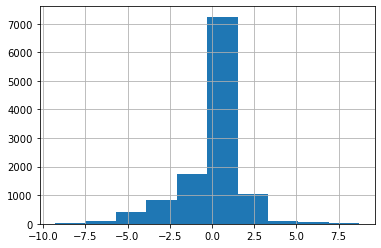

In [64]:
best_submission = pd.read_csv('LSTM_Transfer_Learning-2.6078.csv')
pred_diff = submit.Y18 - best_submission.Y18
pred_diff.hist()
pred_diff.mean(), pred_diff.min(), pred_diff.max()

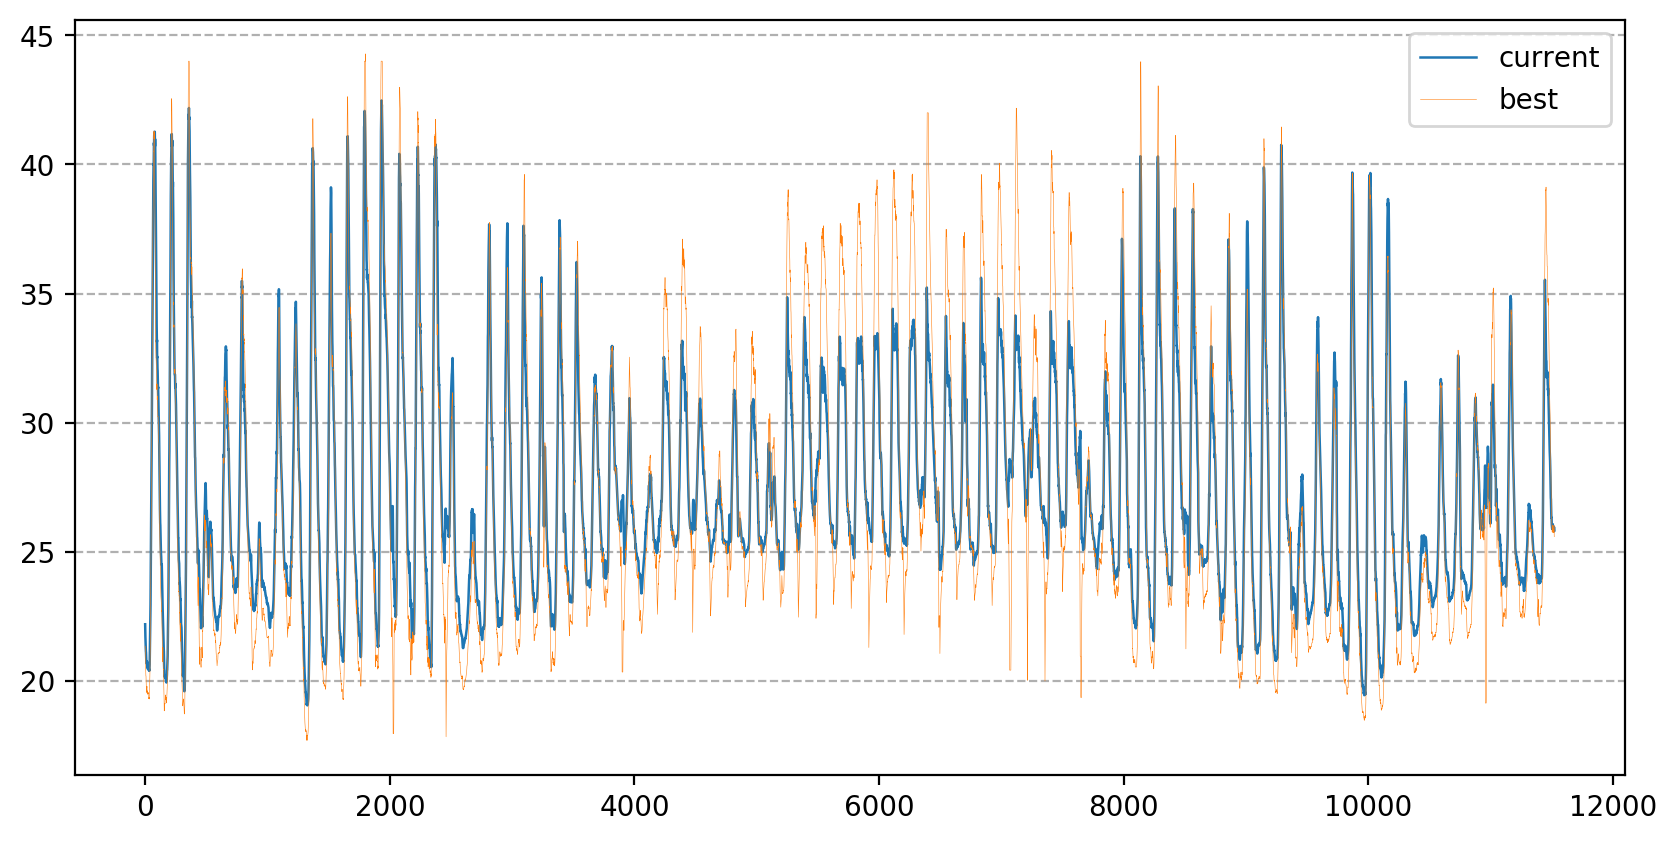

In [65]:
fig, ax = plt.subplots(figsize=(10, 5), dpi=200, sharey=True)
ax.plot(submit.Y18, lw=0.9, label='current')
ax.plot(best_submission.Y18, lw=0.2, label='best')
ax.grid(axis='y', ls='--')
ax.legend();

In [66]:
submit.to_csv('LSTM_Transfer_Learning_ver32.csv', index = False)

### 예측값 상 이상치 제거하기 (Min 값 보간)
1. 80일 Loop를 돈다
2. i번째 day의 min온도를 구한다.
3. i번째 day의 min온도가 i-1번째, i-2번째 min온도의 평균보다 N도 이상 낮으면 그 차이가 N도만 되도록 보간해준다. (N = 2, 3, 4로 테스트 해보기)

In [67]:
def get_min_temp(submit, day):
    min_temp_2days_ago = submit.loc[144*(day-2):144*(day-1)-1, 'Y18'].min()
    min_temp_1day_ago = submit.loc[144*(day-1):144*day-1, 'Y18'].min()
    min_temp_average_ago = (min_temp_2days_ago + min_temp_1day_ago) / 2
    min_temp = submit.loc[144*day:144*(day+1)-1, 'Y18'].min()
    min_temp_idx = submit.loc[144*day:144*(day+1)-1, 'Y18'].idxmin()
    return min_temp_2days_ago, min_temp_1day_ago, min_temp_average_ago, min_temp, min_temp_idx

TOTAL_TEST_DAYS = int(len(test)/144)
    
def interpolate_min_temp(submit, temp_diff_limit, scan_days):
    # Test Day의 3일자부터 시작
    for day in range(2, TOTAL_TEST_DAYS):
        min_temp_2days_ago, min_temp_1day_ago, min_temp_average_ago, min_temp, min_temp_idx = get_min_temp(submit, day)

        # 현재 최저온도가 1, 2일 전 최저온도의 평균보다 temp_diff_limit 낮으면 앞 뒤 scan_days Loop를 돌며 최저온도를 보간해준다.
        if (min_temp_average_ago - min_temp) > temp_diff_limit:
            for idx in range(min_temp_idx - scan_days, min_temp_idx + scan_days + 1):
                if min_temp_average_ago - submit.loc[idx, 'Y18'] > temp_diff_limit:
                    # 온도 보간
                    # 1일 전 min 값 기준으로 보간할지, 1,2일전 평균 min 값 기준으로 보간할지 결정
                    if min_temp_average_ago < min_temp_1day_ago:
                        submit.loc[idx, 'Y18'] = min_temp_1day_ago - temp_diff_limit
                    else:
                        submit.loc[idx, 'Y18'] = min_temp_average_ago - temp_diff_limit                        
    return submit

### 예측값 상 이상치 제거하기 (Max 값 보간)
1. 80일 Loop를 돈다
2. i번째 day의 max온도를 구한다.
3. i번째 day의 max온도가 i-1번째, i-2번째 max온도의 평균보다 N도 이상 높으면 그 차이가 N도만 되도록 보간해준다. (N = 2, 3, 4로 테스트 해보기)

In [68]:
def get_max_temp(submit, day):
    max_temp_2days_ago = submit.loc[144*(day-2):144*(day-1)-1, 'Y18'].max()
    max_temp_1day_ago = submit.loc[144*(day-1):144*day-1, 'Y18'].max()
    max_temp_average_ago = (max_temp_2days_ago + max_temp_1day_ago) / 2
    max_temp = submit.loc[144*day:144*(day+1)-1, 'Y18'].max()
    max_temp_idx = submit.loc[144*day:144*(day+1)-1, 'Y18'].idxmax()
    return max_temp_2days_ago, max_temp_1day_ago, max_temp_average_ago, max_temp, max_temp_idx

TOTAL_TEST_DAYS = int(len(test)/144)
    
def interpolate_max_temp(submit, temp_diff_limit, scan_days):
    # Test Day의 3일자부터 시작
    for day in range(2, TOTAL_TEST_DAYS):
        max_temp_2days_ago, max_temp_1day_ago, max_temp_average_ago, max_temp, max_temp_idx = get_max_temp(submit, day)

        # 현재 최고온도가 1, 2일 전 최고온도의 평균보다 temp_diff_limit 이상 높으면 앞 뒤 scan_days Loop를 돌며 최고온도를 보간해준다.
        if (max_temp - max_temp_average_ago) > temp_diff_limit:
            for idx in range(max_temp_idx - scan_days, max_temp_idx + scan_days + 1):
                if submit.loc[idx, 'Y18'] - max_temp_average_ago > temp_diff_limit:
                    # 온도 보간
                    # 1일 전 max 값 기준으로 보간할지, 1,2일전 평균 max 값 기준으로 보간할지 결정
                    if max_temp_1day_ago > max_temp_average_ago:
                        submit.loc[idx, 'Y18'] = max_temp_average_ago + temp_diff_limit
                    else: 
                        submit.loc[idx, 'Y18'] = max_temp_1day_ago + temp_diff_limit
    return submit

In [69]:
def plot_current_and_best_submit(submit, best_submission):    
    fig, ax = plt.subplots(figsize=(10, 5), dpi=200, sharey=True)
    ax.plot(submit.Y18, lw=0.9, label='current')
    ax.plot(best_submission.Y18, lw=0.3, label='best')
    ax.grid(axis='y', ls='--')
    ax.legend();

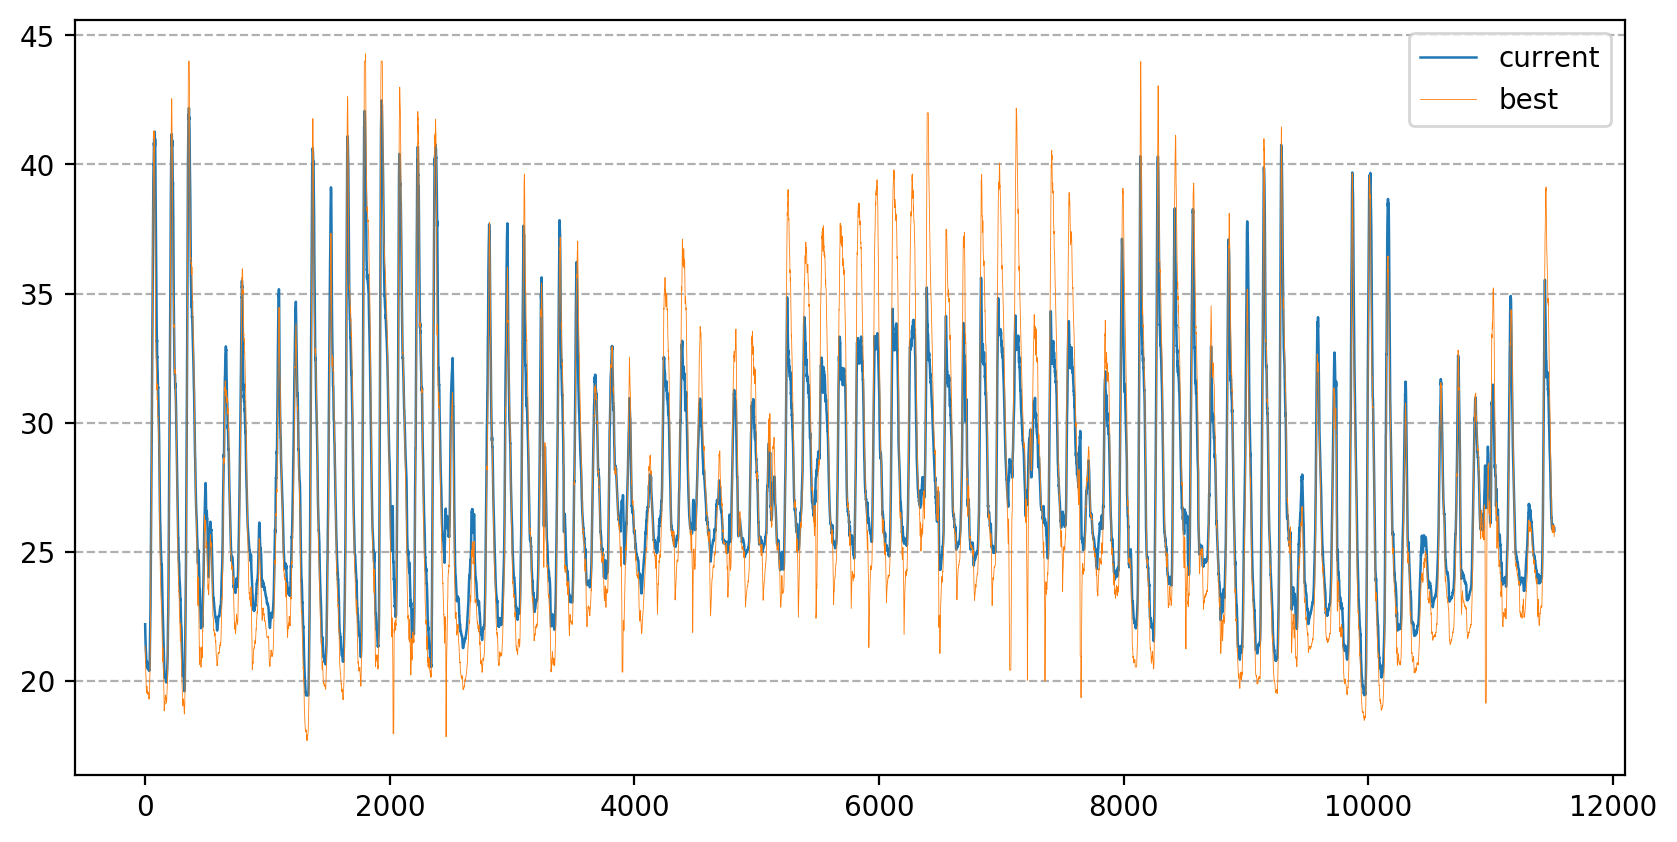

In [70]:
# min값 보간
submit_test = submit.copy()
interpolated_submit_test = interpolate_min_temp(submit_test, temp_diff_limit=2.5, scan_days=12)
plot_current_and_best_submit(interpolated_submit_test, best_submission)

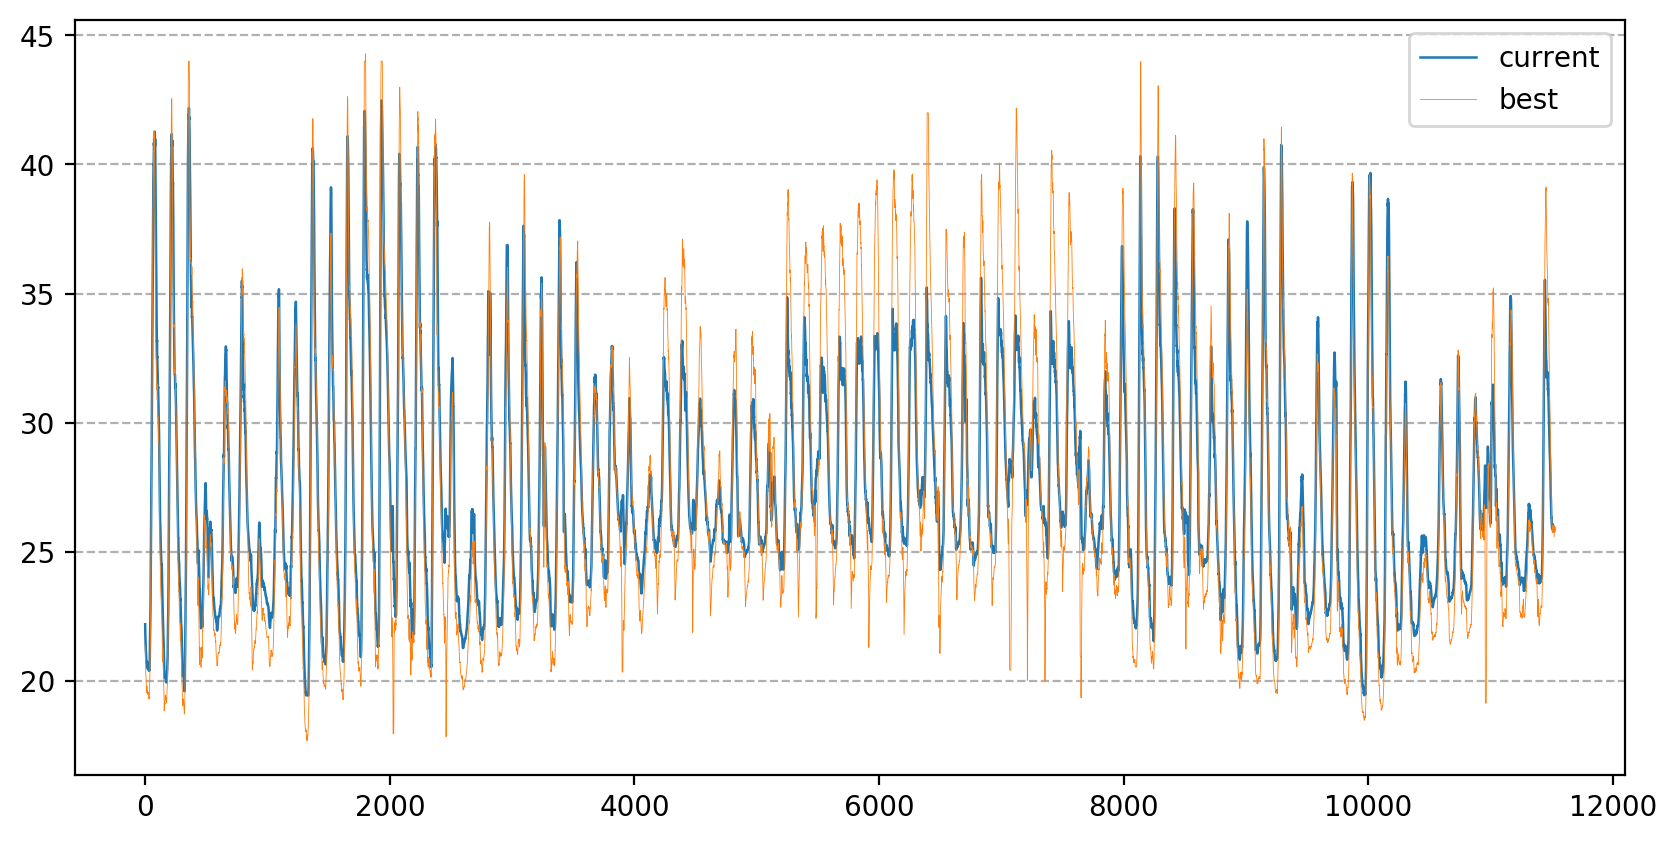

In [71]:
# max값 보간
interpolated_submit_test = interpolate_max_temp(interpolated_submit_test, temp_diff_limit=6, scan_days=12)
plot_current_and_best_submit(interpolated_submit_test, best_submission)

(0.14426680726534527, -9.302341499023434, 8.721139931762696)

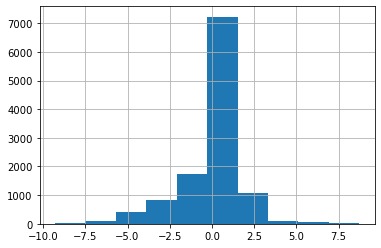

In [72]:
pred_diff = interpolated_submit_test.Y18 - best_submission.Y18
pred_diff.hist()
pred_diff.mean(), pred_diff.min(), pred_diff.max()

In [73]:
# interpolated_submit_test.to_csv('LSTM_Transfer_Learning_ver32.csv', index = False)

#### References
- https://colab.research.google.com/github/tensorflow/examples/blob/master/courses/udacity_intro_to_tensorflow_for_deep_learning/l08c08_forecasting_with_lstm.ipynb